In [1]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, accuracy_score
from joblib import Parallel, delayed, dump, load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [6]:
file_path = 'Global_Dataset.xlsx'
dataset = pd.read_excel(file_path)

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text


In [8]:
dataset['DESCRIPTION'] = dataset['DESCRIPTION'].fillna('').apply(preprocess_text)

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(dataset['DESCRIPTION'])


In [10]:
def find_similar_vulnerability(description, tfidf_matrix, dataset):
    description_tfidf = vectorizer.transform([description])
    cosine_similarities = cosine_similarity(description_tfidf, tfidf_matrix).flatten()
    most_similar_index = np.argmax(cosine_similarities)
    result = dataset.iloc[most_similar_index].drop('ID')
    return result, cosine_similarities[most_similar_index]

In [11]:
def evaluate_model(test_set, tfidf_matrix_train, train_set):
    similarity_scores = []
    for description in test_set['DESCRIPTION']:
        found_vulnerability, similarity_score = find_similar_vulnerability(description, tfidf_matrix_train, train_set)
        similarity_scores.append(similarity_score)
    return similarity_scores

In [12]:
def cross_val_fold(train_index, test_index, dataset, tfidf_matrix):
    train_data, test_data = dataset.iloc[train_index], dataset.iloc[test_index]
    train_tfidf, test_tfidf = tfidf_matrix[train_index], tfidf_matrix[test_index]
    similarity_scores_cv = evaluate_model(test_data, train_tfidf, train_data)
    return mean_squared_error([1] * len(similarity_scores_cv), similarity_scores_cv, squared=False)


In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = Parallel(n_jobs=-1)(delayed(cross_val_fold)(train_index, test_index, dataset, tfidf_matrix) for train_index, test_index in kf.split(dataset))

In [15]:
print(f'Cross-Validation RMSE Scores: {cross_val_scores}')
print(f'Mean Cross-Validation RMSE: {np.mean(cross_val_scores)}')

Cross-Validation RMSE Scores: [0.3234768004059742, 0.32458029978832564, 0.32635819803178595, 0.3252929561499911, 0.3239799759857011]
Mean Cross-Validation RMSE: 0.3247376460723556


In [16]:
train_set, test_set, train_tfidf, test_tfidf = train_test_split(dataset, tfidf_matrix, test_size=0.2, random_state=42)

In [17]:
similarity_scores = evaluate_model(test_set, train_tfidf, train_set)

In [18]:
rmse_value = mean_squared_error([1] * len(similarity_scores), similarity_scores, squared=False)
print(f'RMSE: {rmse_value}')

RMSE: 0.3234768004059742


D:\Anaconda\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
def compute_metrics(similarity_scores):
    true_labels = [1] * len(similarity_scores)
    predicted_labels = [1 if score >= 0.5 else 0 for score in similarity_scores]
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return precision, recall, f1, accuracy

precision_value, recall_value, f1_value, accuracy_value = compute_metrics(similarity_scores)


In [20]:
print(f'Precision: {precision_value}')
print(f'Recall: {recall_value}')
print(f'F1-score: {f1_value}')
print(f'Accuracy: {accuracy_value}')

Precision: 1.0
Recall: 0.8492363035914372
F1-score: 0.9184724547556405
Accuracy: 0.8492363035914372


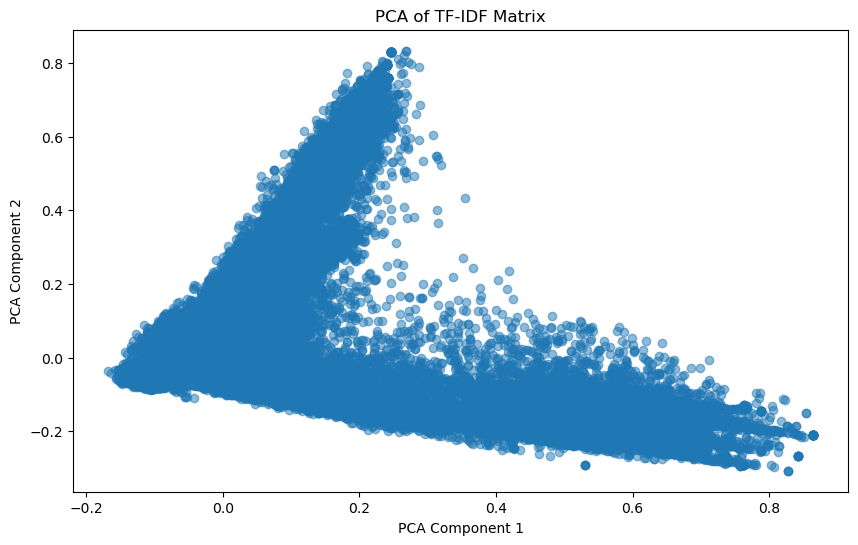

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
tfidf_matrix_train_reduced = pca.fit_transform(train_tfidf.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(tfidf_matrix_train_reduced[:, 0], tfidf_matrix_train_reduced[:, 1], alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of TF-IDF Matrix')
plt.show()

In [22]:
dump(vectorizer, 'vectorizer.joblib')
dump(tfidf_matrix, 'tfidf_matrix.joblib')
dataset.to_pickle('dataset.pkl')


In [7]:
vectorizer = load('vectorizer.joblib')
tfidf_matrix = load('tfidf_matrix.joblib')
dataset = pd.read_pickle('dataset.pkl')

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [9]:
def find_similar_vulnerability(description, tfidf_matrix, dataset):
    description_tfidf = vectorizer.transform([description])
    cosine_similarities = cosine_similarity(description_tfidf, tfidf_matrix).flatten()
    most_similar_index = np.argmax(cosine_similarities)
    result = dataset.iloc[most_similar_index].drop('ID')
    return result, cosine_similarities[most_similar_index]

In [10]:
input_description = "Buffer overflow in NFS mountd allows root access"
input_description = preprocess_text(input_description)
similar_vulnerability, similarity_score = find_similar_vulnerability(input_description, tfidf_matrix, dataset)
print(similar_vulnerability)

CVE-ID                                             CVE-1999-0002
CVSS-V3                                                     None
CVSS-V2                                                       10
SEVERITY                                                    HIGH
DESCRIPTION    buffer overflow in nfs mountd gives root acces...
CWE-ID                                                   CWE-119
Name: 1, dtype: object
